# Wine Dataset

In [23]:
import sys
sys.path.append(r'C:\Users\chaud\OneDrive\Documents\MACHINE LEARNING\utils')

In [70]:
from sklearn.datasets import load_wine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from save_data import save_data
from load_data import load_data
from disp_loss import disp_loss, disp_rel_loss
from tuner import Tuner
from sklearn.metrics import classification_report

In [2]:
wine_data = load_wine(as_frame=True)
wine_df = wine_data.frame
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


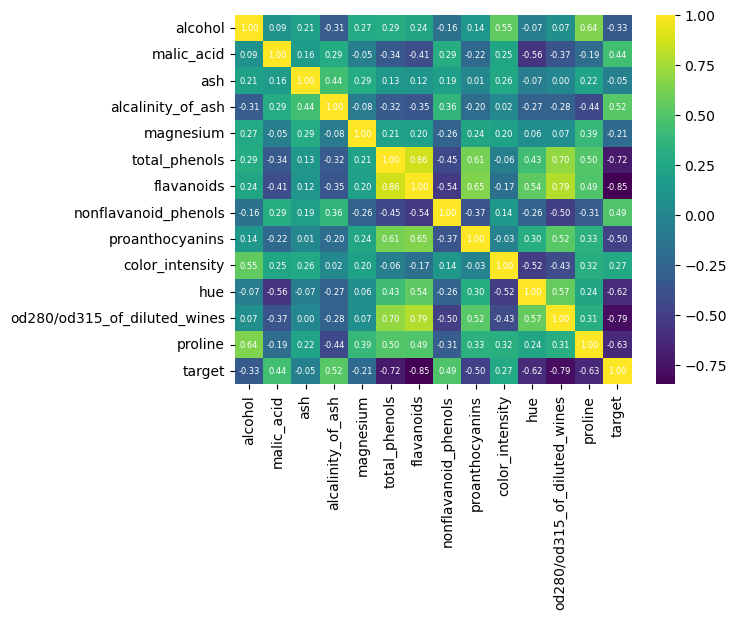

In [3]:
corr_matrix = wine_df.corr()
sns.heatmap(corr_matrix, cmap='viridis', annot=True, fmt=".2f", annot_kws={"size": 6, "color": "white"})
plt.show()

In [4]:
corr_matrix_abs = wine_df.drop(columns='target').corr().abs()

# Set the threshold for highly correlated features
threshold = 0.7

# List of highly correlated features
high_corr_features = np.where(corr_matrix_abs > threshold)
high_corr_pairs = [(corr_matrix_abs.index[x], corr_matrix_abs.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
high_corr_pairs

[('total_phenols', 'flavanoids'),
 ('flavanoids', 'od280/od315_of_diluted_wines')]

In [5]:
wine_df = wine_df.drop(columns=['flavanoids'])
X_df = wine_df.drop(columns='target')
y_df = wine_df['target']

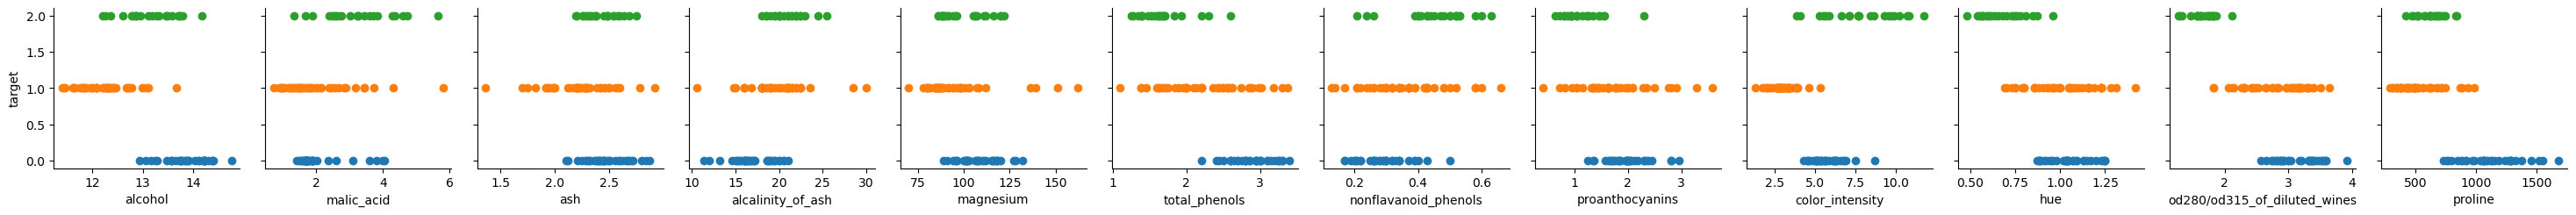

In [6]:
sample_size = 100
sampled_df = wine_df.sample(n=sample_size, random_state=1)
grid = sns.PairGrid(data=sampled_df, y_vars=['target'], x_vars=sampled_df.columns.drop(labels='target'), hue='target')
grid.map(plt.scatter)
plt.show()

In [7]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_df, y_df)
importances = forest.feature_importances_
indices_desc = np.argsort(importances)[::-1]
importances = importances[indices_desc] / importances.max()
imp_features_desc = X_df.columns[indices_desc]

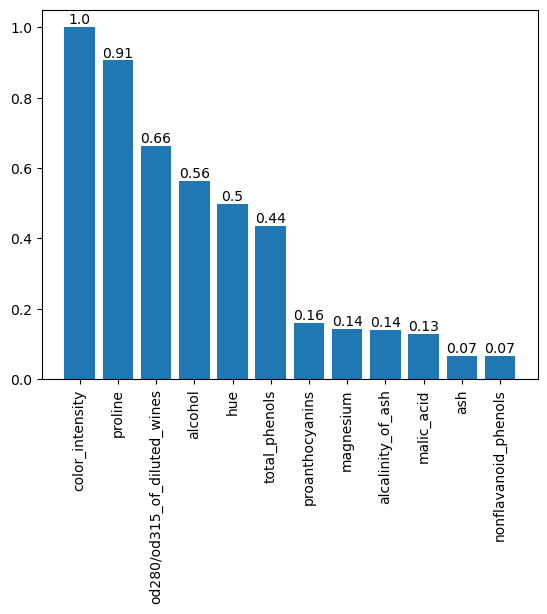

In [8]:
int_idx = np.arange(indices_desc.shape[0])
bars = plt.bar(int_idx, importances)
bar_idx = 0
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, round(yval, 2), ha='center', va='bottom', fontsize=10)
    bar_idx += 1
plt.xticks(int_idx, imp_features_desc, rotation=90)
plt.show()

In [9]:
X_df = X_df[imp_features_desc]     # Sorting features dataframe according to their importance

In [10]:
X_df.head()

,color_intensity,proline,od280/od315_of_diluted_wines,alcohol,hue,total_phenols,proanthocyanins,magnesium,alcalinity_of_ash,malic_acid,ash,nonflavanoid_phenols
0,5.64,1065.0,3.92,14.23,1.04,2.80,2.29,127.0,15.6,1.71,2.43,0.28
1,4.38,1050.0,3.40,13.20,1.05,2.65,1.28,100.0,11.2,1.78,2.14,0.26
2,5.68,1185.0,3.17,13.16,1.03,2.80,2.81,101.0,18.6,2.36,2.67,0.30
3,7.80,1480.0,3.45,14.37,0.86,3.85,2.18,113.0,16.8,1.95,2.50,0.24
4,4.32,735.0,2.93,13.24,1.04,2.80,1.82,118.0,21.0,2.59,2.87,0.39


In [15]:
subset_results = []
# ft_to_rem = X_df.shape[1] - 1
threshold = 0.4     # Remove features whose importance is less than 40% of the most imp feature
ft_to_rem = np.sum(importances < threshold)
mm = MinMaxScaler()
sample_size = X_df.shape[0]
np.random.seed(42)
random_samples = np.random.choice(X_df.index, size=sample_size, replace=False)
X_df_sampled = X_df.loc[random_samples]
y_df_sampled = y_df.loc[random_samples]
X_main_df, X_test_df, y_main_df, y_test_df = train_test_split(X_df_sampled, y_df_sampled, test_size=0.2, random_state=11, stratify=y_df_sampled)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_main_df, y_main_df, test_size=0.1, random_state=42, stratify=y_main_df)
mm.fit(X_train_df)
X_train = mm.transform(X_train_df)
y_train = y_train_df.values
X_val = mm.transform(X_val_df)
y_val = y_val_df.values
X_test = mm.transform(X_test_df)
y_test = y_test_df.values
k = int(np.floor(np.sqrt(X_train.shape[0])))
knn = KNeighborsClassifier(n_neighbors=k)
for i in range(0, ft_to_rem+1):
    if i > 0:
        X_train_filtered = X_train[:, :-i]
        X_val_filtered = X_val[:, :-i]
    else:
        X_train_filtered = X_train
        X_val_filtered = X_val
    knn.fit(X_train_filtered, y_train)
    accuracy = round(knn.score(X_val_filtered, y_val) * 100, 2)
    subset_results.append({
        'features_dropped': i,
        'val_accuracy': accuracy
    })
    print(f'Trial #{i}\n')
    print(f'Features Dropped: {i}')
    print(f'Validation Accuracy: {accuracy}\n\n')

subset_results = sorted(subset_results, key=lambda x: (-x['val_accuracy'], -x['features_dropped']))
print('Best Subset')
print(f"Features Dropped: {subset_results[0]['features_dropped']}")
print(f"Dropped Feature Names: {list(X_df.columns[-subset_results[0]['features_dropped']:])}")
print(f"Validation Accuracy: {subset_results[0]['val_accuracy']}\n\n")

X_test_filtered = X_test[:, :-subset_results[0]['features_dropped']]
X_train_filtered = X_train[:, :-subset_results[0]['features_dropped']]
X_val_filtered = X_val[:, :-subset_results[0]['features_dropped']]

Trial #0

Features Dropped: 0
Validation Accuracy: 93.33


Trial #1

Features Dropped: 1
Validation Accuracy: 93.33


Trial #2

Features Dropped: 2
Validation Accuracy: 93.33


Trial #3

Features Dropped: 3
Validation Accuracy: 93.33


Trial #4

Features Dropped: 4
Validation Accuracy: 93.33


Trial #5

Features Dropped: 5
Validation Accuracy: 86.67


Trial #6

Features Dropped: 6
Validation Accuracy: 86.67


Best Subset
Features Dropped: 4
Dropped Feature Names: ['alcalinity_of_ash', 'malic_acid', 'ash', 'nonflavanoid_phenols']
Validation Accuracy: 93.33




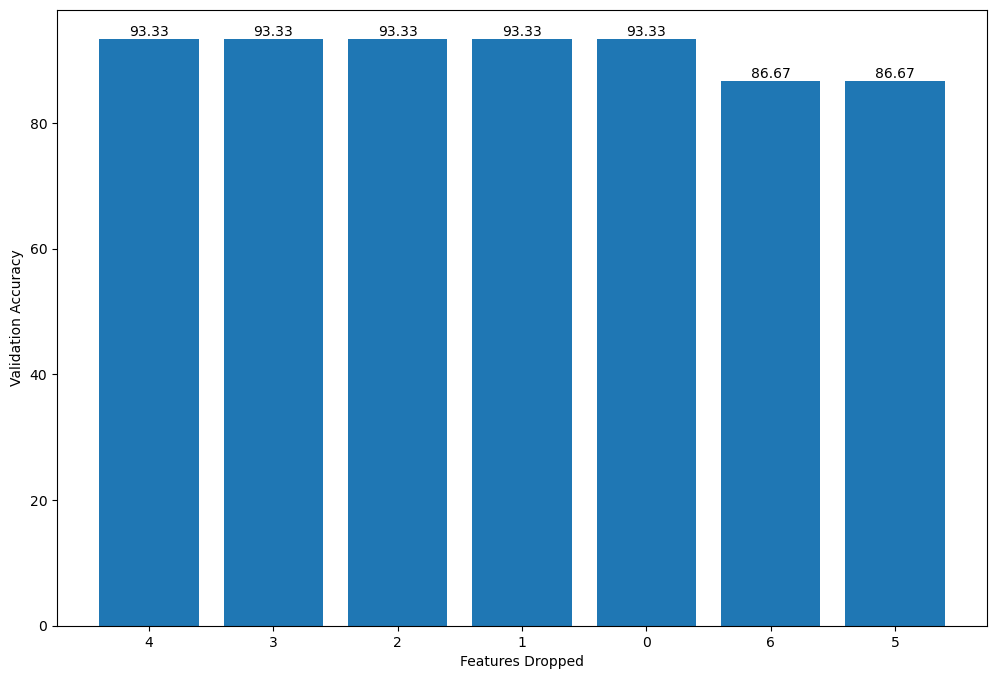

In [12]:
val_accuracy = map(lambda x: x['val_accuracy'], subset_results)
val_accuracy = list(val_accuracy)
ft_dropped = map(lambda x: x['features_dropped'], subset_results)
ft_dropped = list(ft_dropped)
idx = np.arange(0, len(subset_results))
plt.figure(figsize=(12, 8))
bars = plt.bar(idx, val_accuracy)
plt.xlabel('Features Dropped')
plt.ylabel('Validation Accuracy')
plt.xticks(idx, ft_dropped)
# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.show()

In [16]:
save_data(X_train_filtered=X_train_filtered, X_val_filtered=X_val_filtered, y_train=y_train, y_val=y_val)

Data saved successfully!


### NN With 1 Hidden Layer

In [18]:
loaded_vars = load_data(*['models1'])
models1 = loaded_vars['models1']
del loaded_vars
models1

Variable 'models1' has been loaded.


[{'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 1,
  'hidden_layer_neurons': [32],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.15810196101665497,
  'val_loss': 0.13397297263145447},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 1,
  'hidden_layer_neurons': [24],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.12318029999732971,
  'val_loss': 0.14738799631595612},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 1,
  'hidden_layer_neurons': [16],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.1506621539592743,
  'val_loss': 0.1509712189435959},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 1,
  'hidden_layer_neurons': [16],
  'learning_rate': 0.1,
  'regularization_lambda': 0.001,
  'batch_norm': 'no',
  'training_loss': 0.17

### Analyzing Top 10 Models

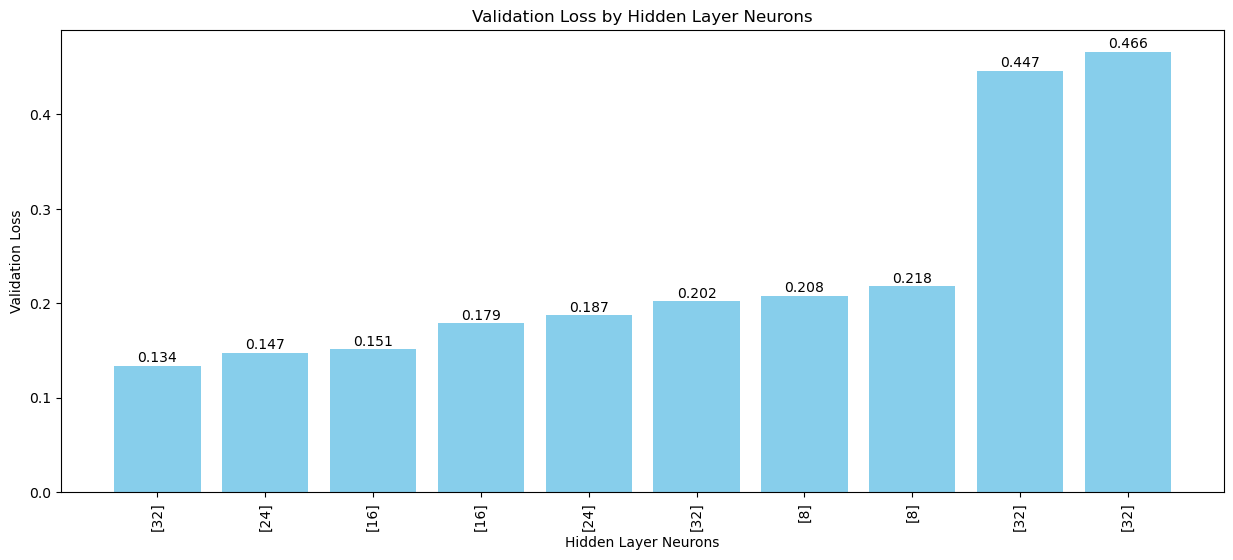

In [25]:
disp_loss(models1)

### NN With 2 Hidden Layers

In [29]:
loaded_vars = load_data(*['models2'])
models2 = loaded_vars['models2']
del loaded_vars
models2

Variable 'models2' has been loaded.


[{'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [24, 24],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.1713355928659439,
  'val_loss': 0.09307093173265457},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [16, 16],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.15799881517887115,
  'val_loss': 0.11096660047769547},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [32, 32],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.1198975071310997,
  'val_loss': 0.12261442840099335},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [8, 8],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'train

### Analyzing Top 10 Models

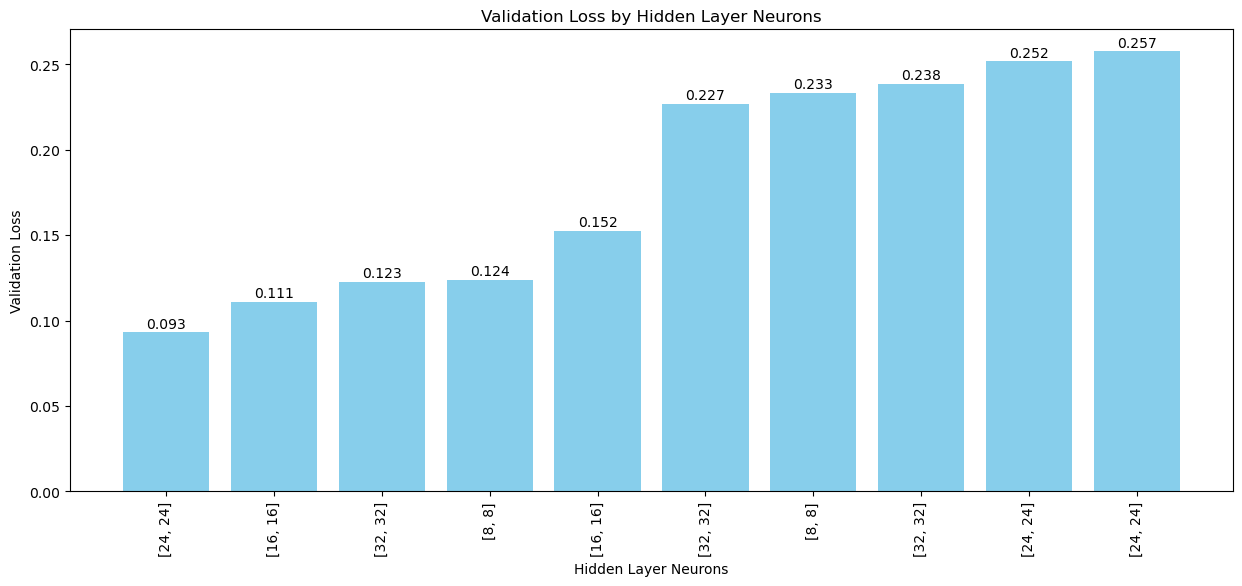

In [30]:
disp_loss(models2)

### NN With 3 Hidden Layers

In [32]:
loaded_vars = load_data(*['models3'])
models3 = loaded_vars['models3']
del loaded_vars
models3

Variable 'models3' has been loaded.


[{'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 3,
  'hidden_layer_neurons': [16, 16, 16],
  'learning_rate': 0.1,
  'regularization_lambda': 0.001,
  'batch_norm': 'no',
  'training_loss': 0.2620217502117157,
  'val_loss': 0.17692802846431732},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 3,
  'hidden_layer_neurons': [24, 24, 24],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.1446465253829956,
  'val_loss': 0.17734773457050323},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 3,
  'hidden_layer_neurons': [32, 32, 32],
  'learning_rate': 0.01,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.1276341825723648,
  'val_loss': 0.18251930177211761},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 3,
  'hidden_layer_neurons': [24, 24, 24],
  'learning_rate': 0.1,
  'regularization_lambda': 0.001,
  'batch_norm'

### Analyzing Top 10 Models

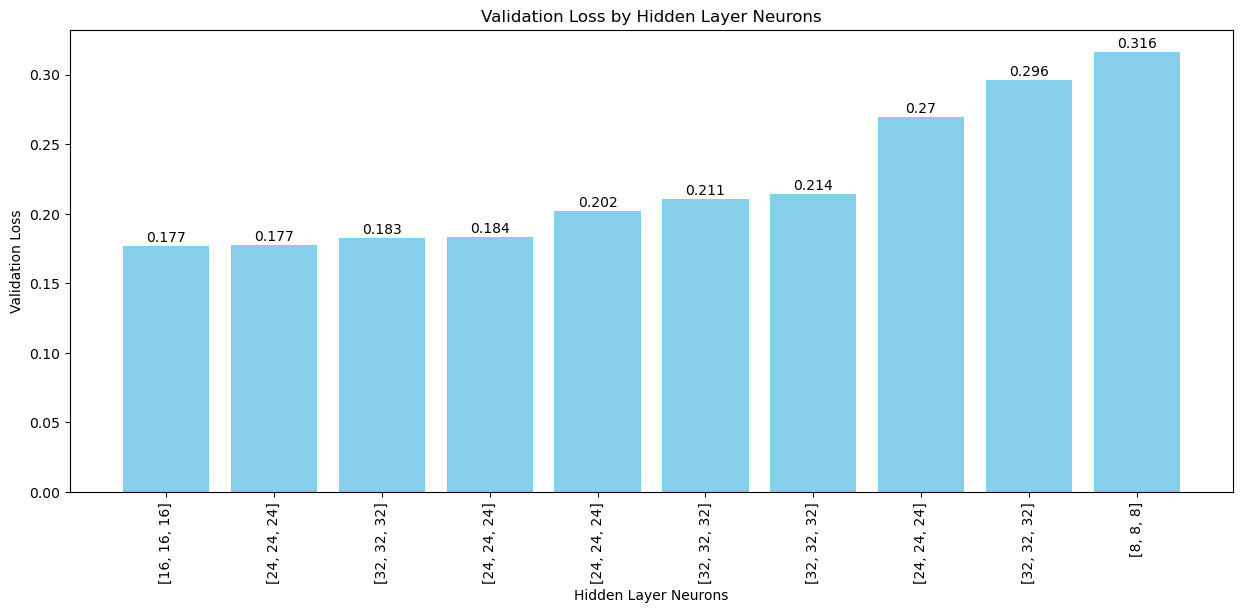

In [33]:
disp_loss(models3)

In [37]:
models_combined = models1 + models2 + models3
models_combined = sorted(models_combined, key=lambda x: x['val_loss'])

### Analyzing Top 10 Combined Models

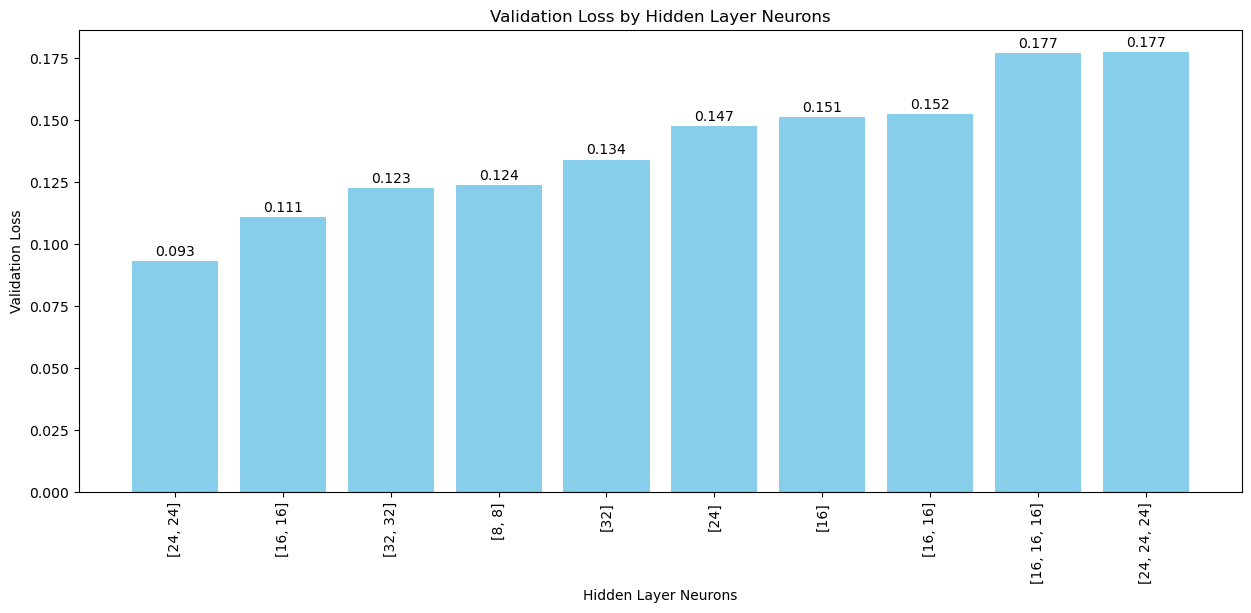

In [38]:
disp_loss(models_combined)

### Analyzing Relative Loss of Top 10 Combined Models

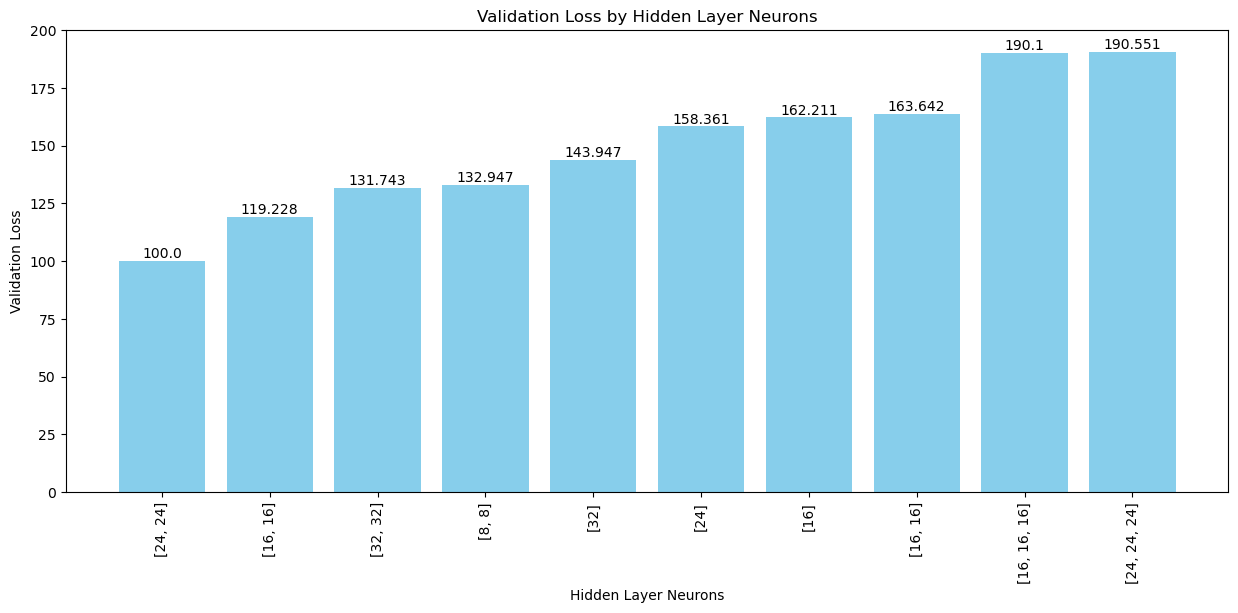

In [39]:
disp_rel_loss(models_combined)

### Turns out 2 hidden layers with 24 neurons are most optimal. Let's see if we can reduce the number of neurons in subsequent hidden layer.

In [40]:
loaded_vars = load_data(*['models2_2'])
models2_2 = loaded_vars['models2_2']
del loaded_vars
models2_2

Variable 'models2_2' has been loaded.


[{'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [24, 8],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.11649029701948166,
  'val_loss': 0.09160640090703964},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [24, 16],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.11221805214881897,
  'val_loss': 0.11303525418043137},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [24, 4],
  'learning_rate': 0.1,
  'regularization_lambda': 0.0001,
  'batch_norm': 'no',
  'training_loss': 0.21307606995105743,
  'val_loss': 0.16117742657661438},
 {'model': <Sequential name=sequential, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [24, 8],
  'learning_rate': 0.1,
  'regularization_lambda': 0.001,
  'batch_norm': 'no',
  'train

In [41]:
models_combined = models_combined + models2_2
models_combined = sorted(models_combined, key=lambda x: x['val_loss'])

### Analyzing Top 10 Combined Models

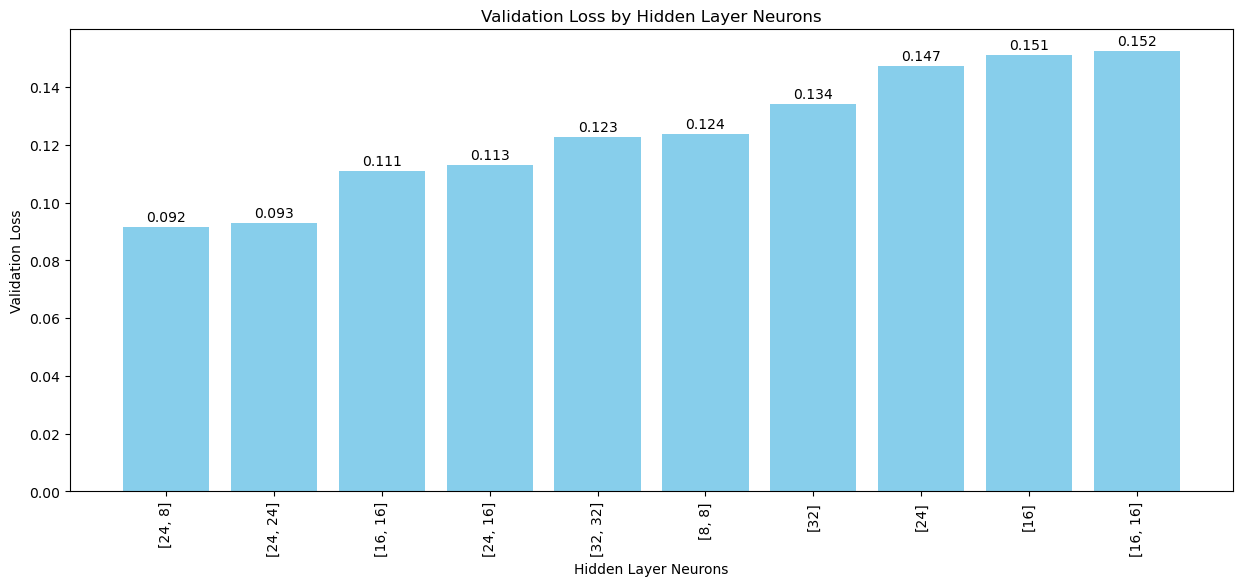

In [42]:
disp_loss(models_combined)

### Analyzing Relative Loss of Top 10 Combined Models

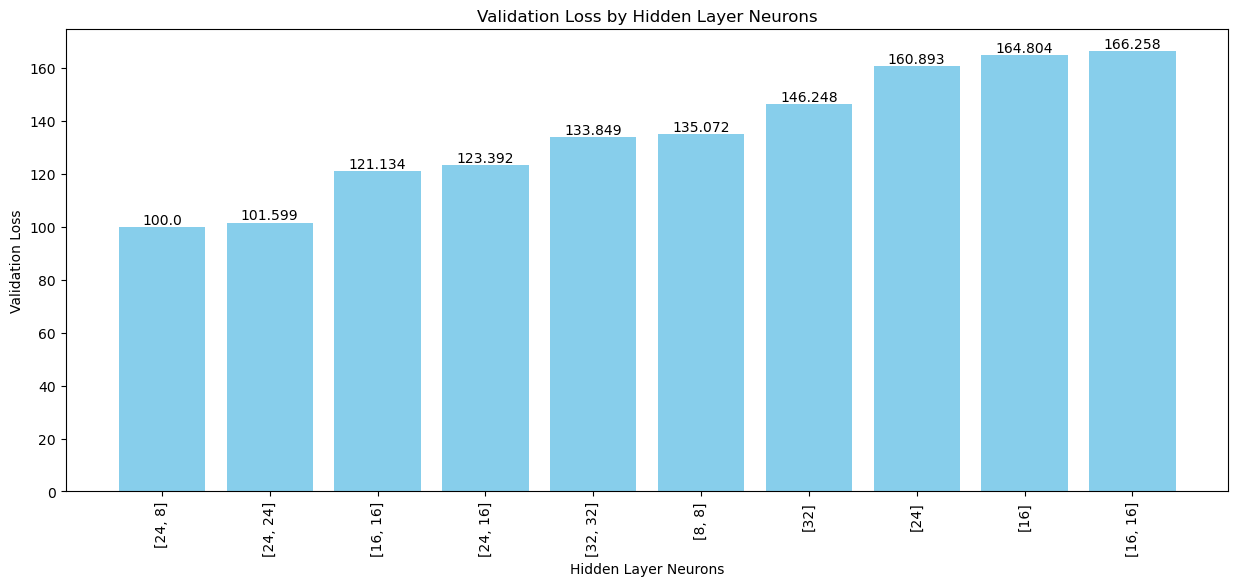

In [43]:
disp_rel_loss(models_combined)

#### The NN with 2 hidden layers with 24 and 8 neurons respectively is most suitable! Let's increase the number of epochs for this model with same hyperparameters.

In [79]:
models_combined[0]

{'model': <Sequential name=sequential, built=True>,
 'hidden_layers': 2,
 'hidden_layer_neurons': [24, 8],
 'learning_rate': 0.1,
 'regularization_lambda': 0.0001,
 'batch_norm': 'no',
 'training_loss': 0.11649029701948166,
 'val_loss': 0.09160640090703964}

In [48]:
monitor = Tuner(monitor='val_loss', restore_best_weights=True, lr_decay=True)
final_model = tf.keras.Sequential([
    tf.keras.Input(shape= (X_train_filtered.shape[1],) ),
    tf.keras.layers.Dense(units=24, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(units=8, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(units=3, kernel_regularizer=tf.keras.regularizers.L2(0.0001))
])
final_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=['accuracy'])
final_model.fit(
    X_train_filtered,
    y_train,
    batch_size=128,
    validation_data=(X_val_filtered, y_val),
    callbacks=[monitor],
    verbose=2,
    epochs=100)

Epoch 1/100
1/1 - 4s - 4s/step - accuracy: 0.4409 - loss: 1.0545 - val_accuracy: 0.6667 - val_loss: 0.8760
Epoch 2/100
1/1 - 0s - 64ms/step - accuracy: 0.6378 - loss: 0.8935 - val_accuracy: 0.5333 - val_loss: 0.8889
Epoch 3/100
1/1 - 0s - 83ms/step - accuracy: 0.4252 - loss: 1.0358 - val_accuracy: 0.5333 - val_loss: 0.8149
Epoch 4/100
1/1 - 0s - 237ms/step - accuracy: 0.5591 - loss: 0.7686 - val_accuracy: 0.6000 - val_loss: 0.8898
Epoch 5/100
1/1 - 0s - 90ms/step - accuracy: 0.6063 - loss: 0.8118 - val_accuracy: 0.8667 - val_loss: 0.4990
Epoch 6/100
1/1 - 0s - 169ms/step - accuracy: 0.8740 - loss: 0.5281 - val_accuracy: 0.7333 - val_loss: 0.4810
Epoch 7/100
1/1 - 0s - 155ms/step - accuracy: 0.7559 - loss: 0.5621 - val_accuracy: 0.6667 - val_loss: 0.4759
Epoch 8/100
1/1 - 0s - 132ms/step - accuracy: 0.7323 - loss: 0.5590 - val_accuracy: 0.8667 - val_loss: 0.3592
Epoch 9/100
1/1 - 0s - 132ms/step - accuracy: 0.8346 - loss: 0.4432 - val_accuracy: 0.9333 - val_loss: 0.3674
Epoch 10/100
1/1

### Since validation loss of this model is greater than the previous one, let's choose that.

In [49]:
final_model = models_combined[0]['model']

In [63]:
test_loss = models_combined[0]['model'].evaluate(X_test_filtered, y_test, verbose=0)
print(f"Test Set Loss: {test_loss}. ({round((test_loss/models_combined[0]['val_loss'])*100, 2)}% of Validation Loss)")

Test Set Loss: 0.12086004763841629. (131.93% of Validation Loss)


#### Though a difference of 31% is huge, however, since the values of loss themselves are very small, this difference becomes insignificant.

In [69]:
logit = final_model.predict(X_test_filtered, verbose=0)
y_pred = np.array(tf.nn.softmax(logit))
y_pred_labels = np.argmax(y_pred, axis=1)
total_decisions = y_pred.shape[0]
correct_decisions = np.sum(y_test == y_pred_labels)
# Calculate accuracy
accuracy = correct_decisions/total_decisions
print(f"Accuracy: {round(accuracy*100, 2)}%")
print(f'Correct Decisions: {correct_decisions}/{total_decisions}')

Accuracy: 94.44%
Correct Decisions: 34/36


### Classification Report

In [72]:
cr = classification_report(y_test, y_pred_labels, target_names=[f'Cat {i+1}' for i in range(3)])
print('Classification Report\n\n', cr)

Classification Report

               precision    recall  f1-score   support

       Cat 1       0.92      0.92      0.92        12
       Cat 2       0.93      0.93      0.93        14
       Cat 3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.94      0.94      0.94        36

